In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

import sys, platform
print("=== Environment Info ===")
print(f"Python envi    : {sys.executable}")
print(f"Python version : {sys.version.split()[0]}")
print(f"Platform       : {platform.platform()}")
print(f"geopandas      : {gpd.__version__}")
print(f"numpy          : {np.__version__}")
print(f"matplotlib     : {plt.matplotlib.__version__}")
print("========================")


=== Environment Info ===
Python envi    : c:\Users\pc\.conda\envs\geo_env\python.exe
Python version : 3.11.13
Platform       : Windows-10-10.0.22631-SP0
geopandas      : 0.14.4
numpy          : 2.2.6
matplotlib     : 3.10.6


In [2]:
from pathlib import Path

# Set the working directory
wd_main     = Path(r"G:\Shared drives\Wellcome Trust Project Data") 
wd_shp      = wd_main / "1_preprocess" / "UrbanCoolingModel" / "OfficialWorkingInputs" / "AOIs"
dir_ucm_out = wd_main / "2_postprocess_intermediate" / "UCM_official_runs"
figures_dir = wd_main / "3_final" / "UCM_figures"


admin_shapefile = wd_shp / "London_Borough_aoi.shp"  # Administrative boundary (e.g., census tracts)
# Load administrative boundaries
aoi_adm = gpd.read_file(admin_shapefile)

In [3]:
import re
from pathlib import Path

def make_short_name(path, base_dir) -> str:
    # --- normalize inputs ---
    # Unwrap single-element tuple/list like (path,) or [path]
    if isinstance(path, (tuple, list)):
        if len(path) == 1:
            path = path[0]
        else:
            raise TypeError(f"Expected a path, got a {type(path).__name__} with len {len(path)}")
    if isinstance(base_dir, (tuple, list)):
        if len(base_dir) == 1:
            base_dir = base_dir[0]
        else:
            raise TypeError(f"Expected a base_dir path, got a {type(base_dir).__name__} with len {len(base_dir)}")

    path = Path(path)
    base_dir = Path(base_dir)

    # find prefix (the first folder under base_dir, e.g. 'current_lulc' or 'scenario2')
    try:
        prefix = path.relative_to(base_dir).parts[0]
    except Exception:
        # fallback: immediate parent if not under base_dir
        prefix = path.parent.name

    # extract deg/uhi numbers from filename
    m = re.search(r"scenario_([\d.]+)deg_([\d.]+)uhi", path.name)
    if not m:
        return prefix

    deg = str(int(float(m.group(1))))
    uhi = str(int(float(m.group(2))))
    return f"{prefix}_{deg}_{uhi}"


## Data

## Productivity results

### map of baseline

`uhi_results_[Suffix].shp`: A copy of the input vector “Area of Interest” with the following additional fields:

avg_cc    - Average CC value (-).

avg_tmp_v  - Average temperature value (degC).

avg_tmp_an - Average temperature anomaly (degC).

avd_eng_cn - (optional) Avoided energy consumption (kWh or $ if optional energy cost input column was provided in the Energy Consumption Table).

avg_wbgt_v - (optional) Average WBGT (degC).

avg_ltls_v - (optional) Light work productivity loss (%).

avg_hvls_v - (optional) Heavy work productivity loss (%).

In [4]:
# var = "avg_tmp_v"  # average temp
# var = "avg_ltls_v" # light work       # --> no much impact 
var = "avg_hvls_v"; var_label = "Work productivity loss (%)" # heavy work
# var = "avd_eng_cn"; var_label = "Avoided energy consumption"


# Load the shapefile
f1 = dir_ucm_out / 'scenario0' / 'work_and_energy_runs' / "uhi_results_london_scenario_25.0deg_5.0uhi_45.0hum_energy_productivity.shp"
gdf_base = gpd.read_file(f1)
print(gdf_base.columns.tolist())
# Ensure avg_hvls_v exists and drop missing values
gdf_base = gdf_base.dropna(subset=[var])


# Load the shapefile
f2 = dir_ucm_out / 'scenario3'  / 'work_and_energy_runs' / "uhi_results_london_scenario3_25.0deg_5.0uhi_45hum_energy_productivity.shp"
f2 = dir_ucm_out / 'scenario43' / 'work_and_energy_runs' / "tcc_30prc" / "uhi_results_london_scenario4_30prc_25.0deg_5.0uhi_45.0hum_energy_productivity.shp"
gdf_new  = gpd.read_file(f2)    # Alternative scenario
gdf_new = gdf_new.dropna(subset=[var])



# Extract suffix
suffix1 = make_short_name(Path(f1), Path(dir_ucm_out) )  
suffix2 = make_short_name(Path(f2), Path(dir_ucm_out) )
suffix_change = f"{suffix1}_VS_{suffix2}"
print(suffix_change)



['NAME', 'GSS_CODE', 'HECTARES', 'NONLD_AREA', 'ONS_INNER', 'SUB_2009', 'SUB_2006', 'avg_cc', 'avg_tmp_v', 'avg_tmp_an', 'avd_eng_cn', 'avg_wbgt_v', 'avg_ltls_v', 'avg_hvls_v', 'geometry']
scenario0_25_5_VS_scenario43


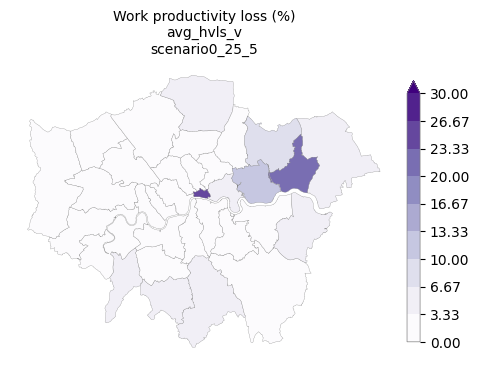

In [5]:
import matplotlib.colors as mcolors

# --- params ---
K = 9  # number of classes (keep small for readability)

# robust max (ignore NaNs)
max_value = np.nanmax([gdf_base[var].to_numpy(dtype=float), gdf_new[var].to_numpy(dtype=float)])

# equal-interval range scaffold
vmin = 0.0
vmax = float(np.ceil(max_value / 10.0) * 10.0)

# --- bins ---
if var == "avd_eng_cn":
    # quantile bins (handle NaNs and duplicate quantiles)
    finite = gdf_new[var].to_numpy(dtype=float)
    finite = finite[np.isfinite(finite)]
    if finite.size == 0:
        # fallback if no finite data
        bins = np.linspace(vmin, vmax if vmax > vmin else vmin + 1, K + 1)
    else:
        q = np.quantile(finite, np.linspace(0, 1, K + 1))
        # Ensure strictly increasing bin edges (dedupe)
        bins = np.unique(q)
        # If too few unique edges, fall back to equal-interval
        if bins.size < 3:  # needs at least 2 bins
            bins = np.linspace(vmin, vmax if vmax > vmin else vmin + 1, K + 1)
else:
    # equal-interval bins
    if vmax <= vmin:
        vmax = vmin + 1.0
    bins = np.linspace(vmin, vmax, K + 1)

extend_mode = 'max'  # 'neither' | 'min' | 'max' | 'both'

# how many color regions do we need?
n_regions = (len(bins) - 1) + (1 if extend_mode in ('min', 'max') else (2 if extend_mode == 'both' else 0))

base_cmap = plt.cm.Purples
cmap = mcolors.ListedColormap(base_cmap(np.linspace(0, 1, n_regions)))

norm = mcolors.BoundaryNorm(boundaries=bins, ncolors=cmap.N, extend=extend_mode)

fig, ax = plt.subplots(figsize=(5, 4))
gdf_base.plot(column=var, ax=ax, cmap=cmap, norm=norm, linewidth=0.2, edgecolor="gray")

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, boundaries=bins, ticks=bins, shrink=0.75, pad=0.02, extend=extend_mode)
# cbar.set_label("%")
cbar.outline.set_edgecolor("gray")
cbar.outline.set_linewidth(0.5)

ax.set_title(f"{var_label}\n{var}\n{suffix1}", fontsize=10)
ax.set_axis_off()
plt.tight_layout()


# Save plot
f = f"{var}_{suffix1}.png"
output_plot_path = figures_dir / f
plt.savefig(output_plot_path, dpi=300, bbox_inches="tight", transparent=True)

plt.show()


### map of scenario

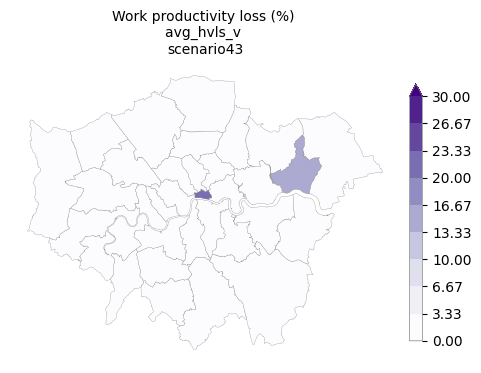

In [6]:
# Plot
fig, ax = plt.subplots(figsize=(5, 4))
gdf_new.plot(column=var, ax=ax, cmap=cmap, norm=norm, linewidth=0.2, edgecolor="gray")


# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, boundaries=bins, ticks=bins, shrink=0.75, pad=0.02, extend=extend_mode)
# cbar.set_label("%")
cbar.outline.set_edgecolor("gray")
cbar.outline.set_linewidth(0.5)

ax.set_title(f"{var_label}\n{var}\n{suffix2}", fontsize=10)
ax.set_axis_off()
plt.tight_layout()


# Clean map
ax.set_title(f"{var_label} \n{var} \n{suffix2}", fontsize=10)
ax.set_axis_off()
plt.tight_layout()

# Save plot
f = f"{var}_{suffix2}.png"
output_plot_path = figures_dir / f
plt.savefig(output_plot_path, dpi=300, bbox_inches="tight", transparent=True)

plt.show()


### change in pd

max change (abs): 9.799473512659452


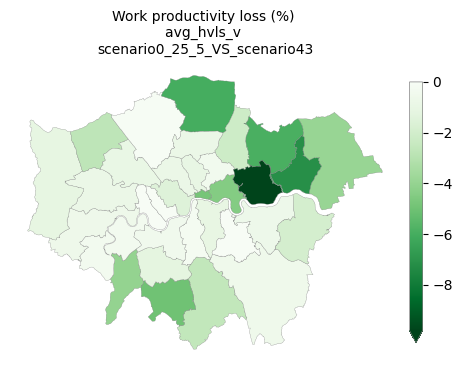

In [7]:

# Ensure same CRS and alignment
gdf_new = gdf_new.to_crs(gdf_base.crs)

# Optional: Merge based on a shared ID column (e.g., 'GEOID' or 'id')
# gdf_merged = gdf_base.merge(gdf_new[["GEOID", "avg_hvls_v"]], on="GEOID", suffixes=("_base", "_new"))

# If geometries match in order (same tract shapes), just copy column
gdf_base["var_new"] = gdf_new[var].values

# --- 2) Compute change ---
gdf_base["var_new"]    = gdf_new[var].to_numpy(dtype=float)
gdf_base["var_change"] = gdf_base["var_new"] - gdf_base[var].to_numpy(dtype=float)
gdf_base = gdf_base.dropna(subset=["var_change"])


# --- 3) Robust min/max and choose colormap + norm ---
vals = gdf_base["var_change"].to_numpy(dtype=float)
finite = vals[np.isfinite(vals)]

if finite.size == 0:
    # degenerate case: nothing to plot
    vmin, vmax = -1.0, 1.0
    cmap = plt.cm.PRGn_r
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    extend_mode = "both"
else:
    vmin_raw, vmax_raw = float(np.min(finite)), float(np.max(finite))
    # If everything is exactly zero, give a small span so we can render
    if vmin_raw == 0.0 and vmax_raw == 0.0:
        vmin_raw, vmax_raw = -1.0, 1.0

    # Mixed signs → diverging
    if (vmin_raw < 0) and (vmax_raw > 0):
        vmax_abs = max(abs(vmin_raw), abs(vmax_raw))
        vmin, vmax = -vmax_abs, vmax_abs
        cmap = plt.cm.PRGn_r            # symmetric diverging
        norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
        extend_mode = "both"
    # All non-negative → sequential
    elif vmin_raw >= 0:
        vmin, vmax = 0.0, vmax_raw
        # avoid zero span
        if vmax <= vmin:
            vmax = vmin + 1.0
        cmap = plt.cm.YlOrRd
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
        extend_mode = "max"
    # All non-positive → sequential
    else:
        vmin, vmax = vmin_raw, 0.0
        if vmax <= vmin:
            vmax = vmin + 1.0
        cmap = plt.cm.Greens_r          # darker = more negative
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
        extend_mode = "min"

print(f"max change (abs): {max(abs(vmin), abs(vmax))}")

# --- 4) Plot ---
fig, ax = plt.subplots(figsize=(5, 4))
gdf_base.plot(
    column="var_change",
    ax=ax,
    cmap=cmap,
    norm=norm,
    edgecolor="gray",
    linewidth=0.2
)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # modern, instead of sm._A
cbar = plt.colorbar(sm, ax=ax, extend=extend_mode, shrink=0.75, pad=0.02)
# cbar.set_label("%")
cbar.outline.set_edgecolor("gray")
cbar.outline.set_linewidth(0.5)

# Final touches
title_var = var_label if 'var_label' in globals() else var
ax.set_title(f"{title_var} \n{var} \n{suffix_change}", fontsize=10)
ax.set_axis_off()
plt.tight_layout()

# --- 5) Save ---
f = f"{var}_Xchange_{suffix_change}.png"
output_plot_path = figures_dir / f
plt.savefig(output_plot_path, dpi=300, bbox_inches="tight", transparent=True)
plt.show()


### zoom in map

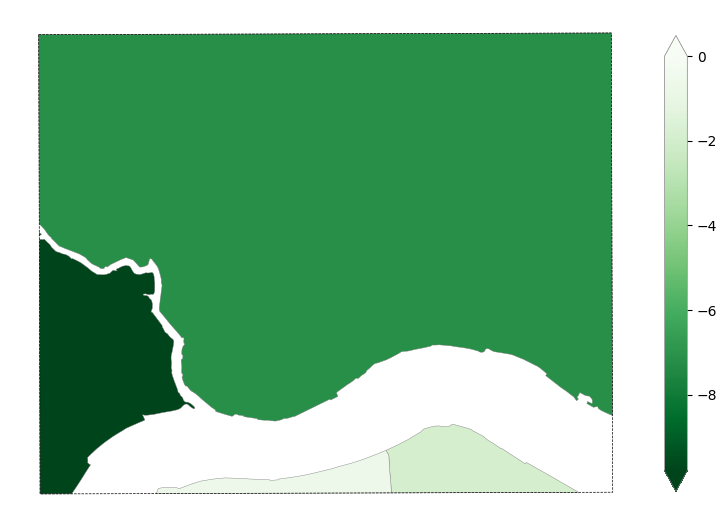

In [8]:
# Load the example region shapefile
f = wd_main / "1_preprocess" / "UrbanCoolingModel" / "zoom in region 1.shp"
zoom_region = gpd.read_file(f).to_crs(gdf_base.crs)

# Clip the difference data to the zoom region
from geopandas.tools import clip
gdf_zoomed = gpd.clip(gdf_base, zoom_region)

# Define color scale again (optional if shared from previous plot)
vmax = np.nanmax(np.abs(gdf_base["var_change"]))


# Plot zoomed-in map
fig, ax = plt.subplots(figsize=(8, 6))
gdf_zoomed.plot(column="var_change", cmap=cmap, norm=norm, ax=ax, edgecolor="gray", linewidth=0.3)

# Overlay boundary
zoom_region.boundary.plot(ax=ax, edgecolor="black", linewidth=0.5, linestyle="--", label="Zoom Region")

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = plt.colorbar(sm, ax=ax, extend = 'both', shrink=0.8, pad=0.03)
# cbar.set_label("%")
cbar.outline.set_edgecolor("gray")       # Change border color
cbar.outline.set_linewidth(0.5)

# Styling
# ax.set_title("Zoomed-in Change in avg_hvls_v", fontsize=14)
ax.set_axis_off()
plt.tight_layout()

# # Save plot
# f = "productivity_loss_changeZoomIn_" + var + ".png"
# output_plot_path = figures_dir / f
# plt.savefig(output_plot_path, dpi=300, bbox_inches="tight", transparent=True)

plt.show()
